In [3]:
import torch

In [35]:
def linear_quantize(tensor, dtype=torch.int8):
    r_min = tensor.min().item()
    r_max = tensor.max().item()
    
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    
    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = torch.round(torch.tensor(q_min - (r_min / scale))).to(torch.int8)

    zero_point = torch.clamp_(torch.tensor(zero_point), min=q_min, max=q_max)
    
    quantized_tensor = torch.round(tensor / scale + zero_point)
    quantized_tensor = torch.clamp_(quantized_tensor, min=q_min, max=q_max).to(torch.int8)
    return scale, zero_point.item(), quantized_tensor

In [36]:
def linear_dequantize(scale, zero_point, tensor, dtype=torch.int):
    r = scale * (tensor.float() - zero_point)
    
    return r

In [37]:

test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [38]:
scale, zero_pt, quant_tensor = linear_quantize(test_tensor)
dequan_tensor = linear_dequantize(scale, zero_pt, quant_tensor)

/var/folders/jn/gs0prjr16mb6pdlzc09xy07c0000gn/T/ipykernel_63124/2183984616.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_point = torch.clamp_(torch.tensor(zero_point), min=q_min, max=q_max)


In [39]:
print("Original Tensor:\n", test_tensor)
print("Quantized Tensor:\n", quant_tensor)
print("Dequantized Tensor:\n", dequan_tensor)

Original Tensor:
 tensor([[ 191.6000,  -13.5000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]])
Quantized Tensor:
 tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)
Dequantized Tensor:
 tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])


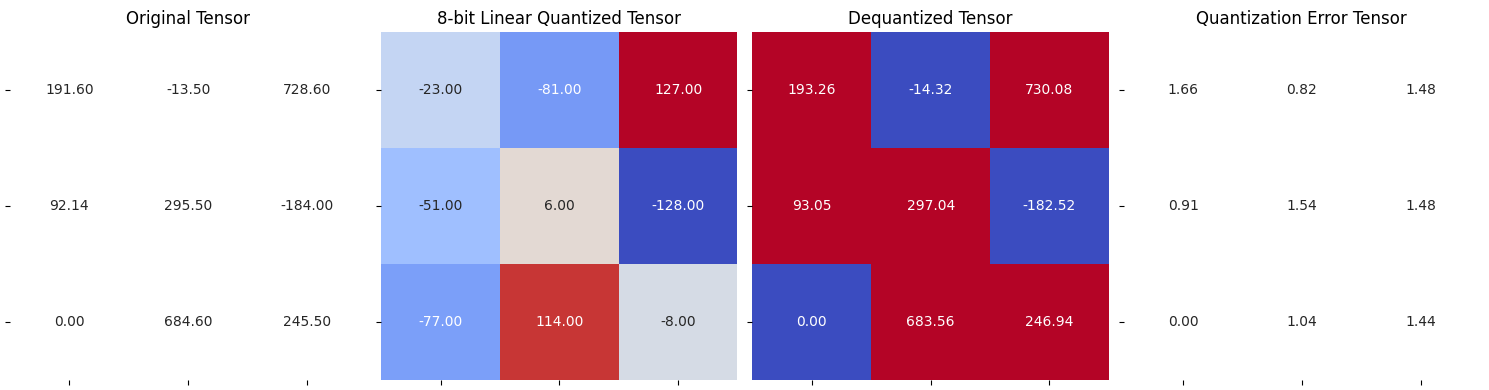

In [40]:

from helper import plot_quantization_errors
plot_quantization_errors(test_tensor, quant_tensor,
                         dequan_tensor)

In [41]:
loss = (dequan_tensor - test_tensor).square().mean()

In [42]:
loss

tensor(1.5730)

In [48]:
##Per channel Quantization

In [50]:
def channel_linear_quantize(tensor, dim=0, dtype=torch.int8):
    scales = torch.zeros(tensor.size(dim))
    zero_pts = torch.zeros(tensor.size(dim), dtype=torch.int8)
    
        
    quantized_tensor = torch.zeros_like(tensor, dtype=torch.int8)
    
    for i in range(tensor.size(dim)):
        scales[i], zero_pts[i], quant = linear_quantize(tensor.select(dim, i), dtype=dtype)

        if dim == 1:
            quantized_tensor[:, i] = quant
        else:
            quantized_tensor[i, :] = quant
            
    if (dim == 0):
        scales = scales.view(scales.shape[dim], -1)
        zero_pts = zero_pts.view(zero_pts.shape[dim], -1)
    elif dim == 1:
        
        scales = scales.view(-1, scales.shape[0])
        zero_pts = zero_pts.view(-1, zero_pts.shape[0])
        
    # quantized_tensor = torch.clamp_(torch.round(tensor / scales + zero_pts), 
    #                                   min=torch.iinfo(dtype).min, 
    #                                   max=torch.iinfo(dtype).max).to(torch.int)
    return scales, zero_pts, quantized_tensor

In [51]:
def channel_linear_dequantize(scales, zero_pts, tensor, dim=0, dtype=torch.int):
    r = torch.zeros_like(tensor, dtype=torch.float)

    r = scales * (tensor.float() - zero_pts)
    return r

In [52]:
scales, zero_pts, quant_tensor = channel_linear_quantize(test_tensor, dim=0)

# scales.shape, zero_pts.shape, quant_tensor.shape
dequantized_tensor = channel_linear_dequantize(scales, zero_pts, quant_tensor, dim=0)

/var/folders/jn/gs0prjr16mb6pdlzc09xy07c0000gn/T/ipykernel_63124/2183984616.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_point = torch.clamp_(torch.tensor(zero_point), min=q_min, max=q_max)


In [53]:
print("Original Tensor:\n", test_tensor)
print("Quantized Tensor:\n", quant_tensor)
print("Dequantized Tensor:\n", dequantized_tensor)

Original Tensor:
 tensor([[ 191.6000,  -13.5000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]])
Quantized Tensor:
 tensor([[ -57, -128,  127],
        [  19,  127, -128],
        [-128,  127,  -37]], dtype=torch.int8)
Dequantized Tensor:
 tensor([[ 192.0729,  -14.5510,  727.5490],
        [  92.1392,  295.2216, -184.2784],
        [   0.0000,  684.6000,  244.3082]])


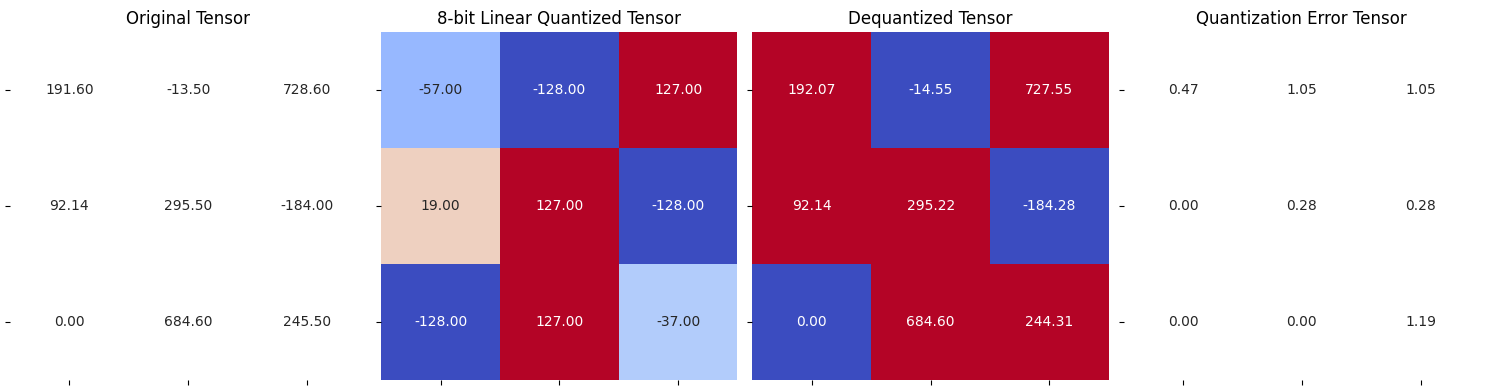

In [54]:
plot_quantization_errors(test_tensor, quant_tensor,
                         dequantized_tensor)

In [55]:
(dequantized_tensor - test_tensor).pow(2).mean()

tensor(0.4453)